In [7]:
import sys
%load_ext autoreload
%autoreload 2

sys.path.append("../libs/")
from data_prep import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from sklearn.metrics import confusion_matrix
from fairlearn.postprocessing import ThresholdOptimizer

# Load prepared data and models

In [9]:




X_train_with_A, X_val_with_A, X_test_with_A, y_train, y_val, y_test, age_train,age_val,age_test,gender_train, gender_val, gender_test, education_train, education_val, education_test = load_stored_data(
     age=True, gender=True, education=True,dataset_name='Default_dataset', scale=True, without_A=False)
X_train_val_with_A, y_train_val = merge_two_sets(X_train_with_A, X_val_with_A, y_train, y_val)
age_train_val, gender_train_val = merge_two_sets(age_train, age_val, gender_train, gender_val)
education_train_val, gender_train_val = merge_two_sets(education_train, education_val, gender_train, gender_val)


##Load models

import joblib

# Load the models from the files

best_rf_A = joblib.load('../ML_models/Default_credit/best_random_forest_A_model.pkl')
best_knn_A = joblib.load('../ML_models/Default_credit/best_knn_A_model.pkl')
best_lr_A = joblib.load('../ML_models/Default_credit/best_logistic_regression_A_model.pkl')

best_lr_big_A =  joblib.load('../ML_models/Default_credit/best_logistic_regression_big_A_model.pkl')
# Now you have the loaded models in the respective variables

##Compute predictions


y_train_pred_lr_A = best_lr_A.predict(X_train_with_A)
y_val_pred_lr_A = best_lr_A.predict(X_val_with_A)
y_test_pred_lr_A=best_lr_big_A.predict(X_test_with_A)
y_train_val_pred_lr_A = best_lr_A.predict(X_train_val_with_A)


y_train_pred_rf_A = best_rf_A.predict(X_train_with_A)
y_val_pred_rf_A = best_rf_A.predict(X_val_with_A)


e:\Python_install\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Chose best treshold ( TO DO : FOR ALL PARAMS OF LOG REG)

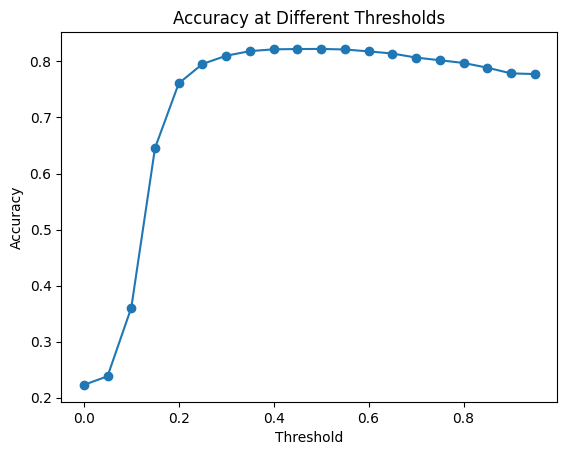

Best treshold is 0.5 and best score is 0.8224444444444444
Best threshold train 0.5


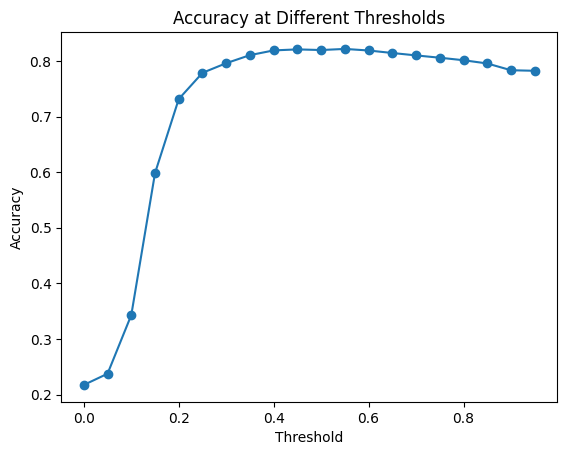

Best treshold is 0.55 and best score is 0.8216666666666667
Best threshold val: 0.55


In [10]:
best_treshold_lr_train=find_best_threshold(y_train, best_lr_A.predict_proba(X_train_with_A))
print("Best threshold train",best_treshold_lr_train)
best_treshold_lr_val=find_best_threshold(y_val, best_lr_A.predict_proba(X_val_with_A))
print("Best threshold val:",best_treshold_lr_val)

# Use fairness optimizer  

In [11]:
threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)

use_fairness_optimizer(threshold_optimizer,X_fit=X_train_with_A, y_fit=y_train_pred_lr_A, X_obs=X_val_with_A, y_obs=y_val_pred_lr_A, 
                        y_train=y_train, y_val=y_val, sensitive_1_fit= age_train, sensitive_2_fit=gender_train, sensitive_1_obs= age_val, sensitive_2_obs=gender_val,
                        name_1="AGE", name_2="GENDER", fitted=False)

            

use_fairness_optimizer(threshold_optimizer,X_fit=X_train_with_A, y_fit=y_train_pred_lr_A, X_obs=X_val_with_A, y_obs=y_val_pred_lr_A, 
                        y_train=y_train, y_val=y_val, sensitive_1_fit= education_train, sensitive_2_fit=gender_train, sensitive_1_obs= education_val, sensitive_2_obs=gender_val,
                        name_1="EDUCATION", name_2="GENDER", fitted=False)



threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)
use_fairness_optimizer(threshold_optimizer,X_fit=X_train_with_A, y_fit=y_train_pred_lr_A, X_obs=X_val_with_A, y_obs=y_val_pred_lr_A, 
                        y_train=y_train, y_val=y_val, sensitive_1_fit= gender_train, sensitive_2_fit=age_train, sensitive_1_obs= gender_val, sensitive_2_obs=age_val,
                        name_1="GENDER", name_2="AGE", fitted=False)


print()
print("VERIFICA")
print()


threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)
threshold_optimizer.predict_method='auto'
threshold_optimizer.fit(X_train_with_A, y_train, sensitive_features=gender_train)

############################################# ALEGE SENS FEATURE BUN #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
adjusted_gender_train = threshold_optimizer.predict(X_train_with_A, sensitive_features = gender_train)

adjusted_gender_val = threshold_optimizer.predict(X_val_with_A,sensitive_features=gender_val)


print()
print()

print("--------- SCORES AFTER OPTIMIZING FOR GENDER ---------")
print()
print("----- accuracy scores -----")


print(f' acc score train got from : {accuracy_score(y_train_pred_lr_A, y_train)} to {accuracy_score(adjusted_gender_train, y_train)}')
print(f" acc score val from : {accuracy_score(y_val_pred_lr_A, y_val)} to {accuracy_score(adjusted_gender_val, y_val)}")

print("----- Scores for fariness -----")

print(f'Gender train eq op went from: {eq_op_dif(y_train,y_train_pred_lr_A, sensitive_attribute=gender_train)} to {eq_op_dif(y_train, adjusted_gender_train, sensitive_attribute=gender_train)}')
print(f"Gender val eq op went from :  {eq_op_dif(y_val,y_val_pred_lr_A, sensitive_attribute=gender_val)} to {eq_op_dif(y_val, adjusted_gender_val, sensitive_attribute=gender_val)}")
print(f'Age train eq op went from: {eq_op_dif(y_train,y_train_pred_lr_A, sensitive_attribute=age_train)} to {eq_op_dif(y_train, adjusted_gender_train, sensitive_attribute=age_train)}')
print(f"Age val eq op went from :  {eq_op_dif(y_val,y_val_pred_lr_A, sensitive_attribute=age_val)} to {eq_op_dif(y_val, adjusted_gender_val, sensitive_attribute=age_val)}")









--------- SCORES AFTER OPTIMIZING FOR AGE ---------

----- accuracy scores -----
 acc score train got from : 0.8224444444444444 to 0.8231666666666667
 acc score val from : 0.8196666666666667 to 0.8205

----- Scores for fariness -----
AGE train eq op went from: 0.008004041311180932 to 0.0008381978745696794
AGE val eq op went from :  0.03302147820742568 to 0.04906949746033912
GENDER train eq op went from: -0.05464016399776367 to -0.060155240307329105
GENDER val eq op went from :  0.012051580376187698 to 0.011925538103548572
--------- SCORES AFTER OPTIMIZING FOR EDUCATION ---------

----- accuracy scores -----
 acc score train got from : 0.8224444444444444 to 0.8223888888888888
 acc score val from : 0.8196666666666667 to 0.8188333333333333

----- Scores for fariness -----
EDUCATION train eq op went from: 0.11520159523845491 to 0.001558285815880578
EDUCATION val eq op went from :  0.06553419659146531 to 0.06746985271214345
GENDER train eq op went from: -0.05464016399776367 to -0.0630877760

# Do the same on test set

In [12]:

threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)

use_fairness_optimizer(threshold_optimizer,X_fit=X_train_val_with_A, y_fit=y_train_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A, 
                        y_train=y_train_val, y_val=y_test, sensitive_1_fit= age_train_val, sensitive_2_fit=gender_train_val, sensitive_1_obs= age_test, sensitive_2_obs=gender_test,
                        name_1="AGE", name_2="GENDER", fitted=False, name_dataset1="train_val",name_dataset2="test")


use_fairness_optimizer(threshold_optimizer,X_fit=X_train_val_with_A, y_fit=y_train_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A, 
                        y_train=y_train_val, y_val=y_test, sensitive_1_fit= education_train_val, sensitive_2_fit=gender_train_val, sensitive_1_obs= education_test, sensitive_2_obs=gender_test,
                        name_1="EDUCATION", name_2="GENDER", fitted=False, name_dataset1="train_val",name_dataset2="test")

threshold_optimizer = ThresholdOptimizer(estimator=best_lr_A, constraints="true_positive_rate_parity", objective= "accuracy_score", prefit=True)
use_fairness_optimizer(threshold_optimizer,X_fit=X_train_val_with_A, y_fit=y_train_val_pred_lr_A, X_obs=X_test_with_A, y_obs=y_test_pred_lr_A, 
                        y_train=y_train_val, y_val=y_test, sensitive_1_fit= gender_train_val, sensitive_2_fit=age_train_val, sensitive_1_obs= gender_test, sensitive_2_obs=age_test,
                        name_1="GENDER", name_2="AGE", fitted=False, name_dataset1="train_val", name_dataset2="test")













e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


--------- SCORES AFTER OPTIMIZING FOR AGE ---------

----- accuracy scores -----
 acc score train_val got from : 0.82175 to 0.823125
 acc score test from : 0.8155 to 0.8161666666666667

----- Scores for fariness -----
AGE train_val eq op went from: 0.0021101959009210414 to 0.0002477655663509215
AGE test eq op went from :  0.01072007850941159 to 0.0011517439720855616
GENDER train_val eq op went from: -0.04409206482438949 to -0.043404564013147184
GENDER test eq op went from :  0.006818574544299738 to 0.033051405513704835


e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


--------- SCORES AFTER OPTIMIZING FOR EDUCATION ---------

----- accuracy scores -----
 acc score train_val got from : 0.82175 to 0.822125
 acc score test from : 0.8155 to 0.813

----- Scores for fariness -----
EDUCATION train_val eq op went from: 0.10319231892329539 to 0.0017108878299996189
EDUCATION test eq op went from :  0.11672076857498853 to 0.033163376833453606
GENDER train_val eq op went from: -0.04409206482438949 to -0.05027005354920305
GENDER test eq op went from :  0.006818574544299738 to 0.01527173887661648
--------- SCORES AFTER OPTIMIZING FOR GENDER ---------

----- accuracy scores -----
 acc score train_val got from : 0.82175 to 0.8224583333333333
 acc score test from : 0.8155 to 0.8166666666666667

----- Scores for fariness -----
GENDER train_val eq op went from: 0.04409206482438949 to 0.0015763339347342753
GENDER test eq op went from :  0.006818574544299738 to 0.02092041415834972
AGE train_val eq op went from: -0.0021101959009210414 to -0.0027342243617303197
AGE test e

e:\Python_install\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
